In [1]:
import seaborn
import re
import pandas as pd
import csv
import numpy as np

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
stopwords = set(stopwords.words('english'))

In [6]:
# load data from csv
scp_df = pd.read_csv('scp6999.csv', header=0, delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8', index_col=False, usecols=['code', 'title', 'text', 'image captions', 'rating', 'state', 'tags',  'link'])

scp_df.head # quick check - note excel limits will mean opening in excel will cause issues (cells running into others etc)

<bound method NDFrame.head of           code                                              title  \
0      SCP-001             "Awaiting De-classification [Blocked]"   
1      SCP-002                                "The "Living" Room"   
2      SCP-003                           "Biological Motherboard"   
3      SCP-004                   "The 12 Rusty Keys and the Door"   
4      SCP-005                                     "Skeleton Key"   
...        ...                                                ...   
6994  SCP-6995                                  "Cannabincognito"   
6995  SCP-6996                          "Does the Red Moon Howl?"   
6996  SCP-6997                                  "De Rerum Natura"   
6997  SCP-6998  "SCP Author Cerastes's Untitled SCP-6000 Conte...   
6998  SCP-6999                          "Nearer, My God, To Thee"   

                                                   text  \
0     "GENERAL NOTICE 001-Alpha: In order to prevent...   
1     "Item #: SCP-002 

In [7]:
# setting up some functions for later use - each takes single string of words space separated, including if prefiltered by pos

In [8]:
def quick_clean(text):
  text = text.lower()
  clean_text = re.sub('[^a-zA-Z ]', '', text)
  return clean_text

In [9]:
def remove_stopwords(text):
  return " ".join([i for i in text.split() if i not in stopwords])

In [10]:
def pos_tag(text):
  return nltk.pos_tag(text.split())

In [11]:
def create_wordcloud(text):
  wordcloud = WordCloud(max_font_size=80, max_words=50, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

In [12]:
def get_most_common(text):
  text = text.split()
  word_counts = {}
  for i in text:
    word_counts[i] = text.count(i)
  return sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:20]

In [141]:
def plot_most_common(text, label='Word', clr="rocket", title= None):
  bar = seaborn.barplot([i[1] for i in text], [i[0] for i in text], orient= 'h', palette=clr)
  if title:
    bar.set_title(title)
  seaborn.despine(left=True, bottom=True)
  bar.set_xlabel('Frequency')
  bar.set_ylabel(label)

## Title Analysis

Examining the text titles of SCP articles from the main series 1 to 7

In [14]:
# extracting and preprocessing title text:
titles_raw = scp_df['title'].apply(lambda x: quick_clean(x))

### "Access Denied"

A significant minority of titles (and their articles) are not available.




In [15]:
access_denied_count = len([i for i in list(scp_df['title']) if "access denied" in i.lower()])
print("Number of titles unavailable: {}".format(access_denied_count))
print("Percentage of titles unavailable: {}%".format(round(access_denied_count / len(scp_df) * 100, 1)))

Number of titles unavailable: 410
Percentage of titles unavailable: 5.9%


In [16]:
# plotting the general distribution of unavailable titles
def get_unavailable_by_slice(data, slice_size):
  x_y_dict = {}
  for i in range(0, len(data), slice_size):
    x_y_dict["{}-{}".format(i, i + slice_size)] = len([i for i in list(data)[i: i + slice_size] if "access denied" in i.lower()])
  print("Unavailable by range: {}".format(x_y_dict))
  return [list([int(i.split("-")[1]) for i in x_y_dict.keys()]), list(x_y_dict.values())]


Unavailable by range: {'0-250': 0, '250-500': 0, '500-750': 0, '750-1000': 0, '1000-1250': 0, '1250-1500': 0, '1500-1750': 0, '1750-2000': 1, '2000-2250': 0, '2250-2500': 0, '2500-2750': 0, '2750-3000': 0, '3000-3250': 0, '3250-3500': 0, '3500-3750': 0, '3750-4000': 1, '4000-4250': 0, '4250-4500': 1, '4500-4750': 0, '4750-5000': 0, '5000-5250': 0, '5250-5500': 2, '5500-5750': 4, '5750-6000': 1, '6000-6250': 42, '6250-6500': 114, '6500-6750': 118, '6750-7000': 126}


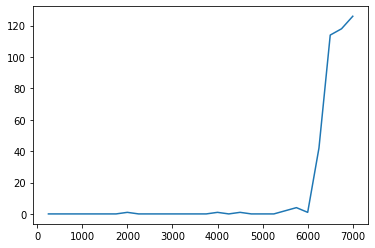

In [17]:
x_y = get_unavailable_by_slice(scp_df['title'], 250)
plt.plot(x_y[0], x_y[1])

We can see that the vast majority of unavailable articles and titles are found in the final or 7th series, from index 6000 onwards.

These unavailable titles will be removed from further analysis to avoid skewing results (their titles are identical).

In [18]:
# removing access denied from titles cleaned info
titles = [i for i in titles_raw if "access denied" not in i.lower()]

titles_nostopwords = [remove_stopwords(i) for i in titles]
titles_single_str = " ".join(titles)
titles_nostopwords_single_str = " ".join(titles_nostopwords)
pos_tagged = pos_tag(titles_single_str)

## Most Common ...

A look at the most common words of various types within the filtered titles

In [19]:
# getting some bits of data for further use
nouns_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='NN'])
adjectives_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='JJ'])
verbs_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='VB'])

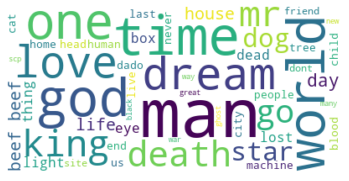

In [20]:
create_wordcloud(titles_nostopwords_single_str)

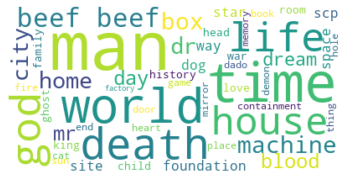

In [21]:
create_wordcloud(nouns_as_str)

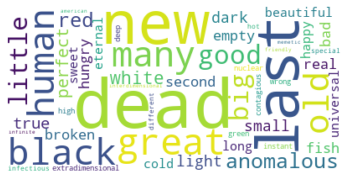

In [22]:
create_wordcloud(adjectives_as_str)

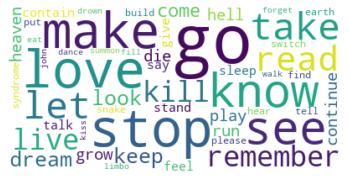

In [23]:
create_wordcloud(verbs_as_str)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


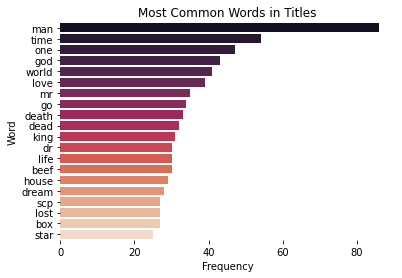

In [152]:
plot_most_common(get_most_common(titles_nostopwords_single_str), title='Most Common Words in Titles')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


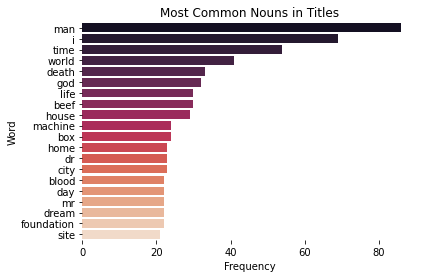

In [151]:
plot_most_common(get_most_common(nouns_as_str), title='Most Common Nouns in Titles')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


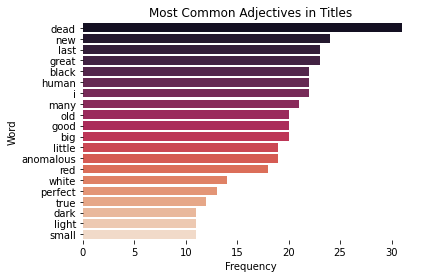

In [150]:
plot_most_common(get_most_common(adjectives_as_str), title='Most Common Adjectives in Titles')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


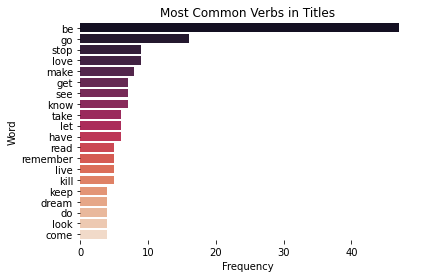

In [149]:
plot_most_common(get_most_common(verbs_as_str), title='Most Common Verbs in Titles')

## Ratings

Examining the ratings independent of other fields

### NaN

Blocked or unavailable articles do not have an accessible rating, and a quick look shows us there are other articles with no rating

In [28]:
# no rating - key numbers
no_rating_num = len([i for i in list(scp_df['rating']) if np.isnan(i)])
print("Number of entries with no rating: {}".format(no_rating_num))
print("Percentage of entries with no rating: {}%".format(round(no_rating_num / len(scp_df)*100, 1)))

Number of entries with no rating: 398
Percentage of entries with no rating: 5.7%


In [29]:
# investigating entries with no rating that are not blocked
no_rating = scp_df[scp_df['rating'].isna()]
no_rating_not_blocked = no_rating[~no_rating['title'].str.contains("access denied", case=False)]

In [30]:
list(no_rating_not_blocked['link'])

['https://scp-wiki.wikidot.com/scp-001',
 'https://scp-wiki.wikidot.com/scp-2721',
 'https://scp-wiki.wikidot.com/scp-5468',
 'https://scp-wiki.wikidot.com/scp-5489',
 'https://scp-wiki.wikidot.com/scp-5674',
 'https://scp-wiki.wikidot.com/scp-6286',
 'https://scp-wiki.wikidot.com/scp-6351',
 'https://scp-wiki.wikidot.com/scp-6682']

Most of these are deleted, some just don't have ratings or are blocked in some way

For now, all rows with missing ratings will be filtered out.


In [31]:
# filtering out nan ratings with dropna - size of resulting dataframe also suggests there are no other columns with null values
no_nan_ratings_df = scp_df[scp_df['rating'].notna()]
# no_nan_ratings_df

In [32]:
ratings_list = list(no_nan_ratings_df['rating'])

In [33]:
# average rating - mode median mean
most_frequent_rating = max(ratings_list, key=ratings_list.count)
print("Most common rating: {}. Number of articles with this rating: {}.".format(int(most_frequent_rating), len(scp_df.loc[scp_df['rating']==most_frequent_rating])))

median_rating = sorted(ratings_list)[len(ratings_list)//2]
print("Median rating: {}".format(int(median_rating)))

average_rating = sum(ratings_list)/len(ratings_list)
print("Average rating: {}".format(int(average_rating)))

Most common rating: 55. Number of articles with this rating: 49.
Median rating: 107
Average rating: 171


In [34]:
highest_rated_article = scp_df.loc[scp_df['rating']==max(ratings_list)]
print("Highest rated article: {} {}. Rating: {}".format(highest_rated_article.code.item(), highest_rated_article.title.item(), int(max(ratings_list))))

lowest_rated_article = scp_df.loc[scp_df['rating']==min(ratings_list)]
print("Lowest rated article: {} {}. Rating: {}".format(lowest_rated_article.code.item(), lowest_rated_article.title.item(), int(min(ratings_list))))

# this lowest, negative rating looks suspicious at first, but downvotes are allowed and checking the link shows that it is accurate

Highest rated article: SCP-173 "The Original". Rating: 7651
Lowest rated article: SCP-6980 "What kind of kid drinks a lava lamp?". Rating: -35


{'boxes': [<matplotlib.lines.Line2D at 0x7fbb57ec6090>],
 'caps': [<matplotlib.lines.Line2D at 0x7fbb57ecd050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb57ed3090>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fbb57ecdb10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbb57ec6590>,
  <matplotlib.lines.Line2D at 0x7fbb57ec6ad0>]}

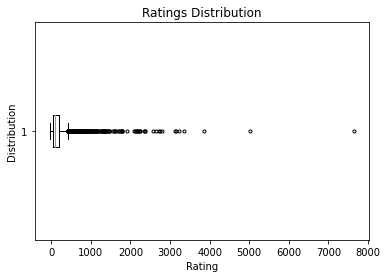

In [35]:
# rating boxplot
fig1, ax1 = plt.subplots()
ax1.set_title('Ratings Distribution')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Distribution')
ax1.boxplot(ratings_list, vert= False, sym='.')

## Tags


In [55]:
# getting all tags
all_tags = [str(i).split() for i in list(scp_df['tags'])]
from itertools import chain
all_tags = list(chain.from_iterable(all_tags))
# print(all_tags)
unique_tags = list(set(all_tags))
print(len(unique_tags)) 
print(len([i for i in unique_tags if i[0]!="_"]))
print([i for i in unique_tags if i[0]=="_"])

525
505
['_graveyard-shift', '_all-a-dream', '_cc', '_explosions', '_the-bureaucrat', '_corruption', '_image', '_pulp-fiction', '_listpages', '_llicensebox', '_shaggy-dog', '_murder-mystery', '_marine', '_delicious', '_famouslastwords', '_tropical', '_townhouse', '_dark-and-stormy', '_meets-the-eye', '_licensebox']


We see that there are 525 unique tags across this dataset, with 20 of these being hidden tags that do not display on the page, and the other 505 of these being tags the user sees. 

In [56]:
# most common tags
common_tags = sorted(unique_tags, reverse=True, key=lambda x: len([i for i in list(scp_df['tags']) if x in str(i).split()]))
most_common_tags = " ".join(common_tags[:20])
print('Most common tags: {}'.format(most_common_tags))

common_tags_visible = [i for i in common_tags if i[0]!="_"]
most_common_visible_tags = " ".join(common_tags_visible[:20])
print('Most common visible tags: {}'.format(most_common_visible_tags))

#plot
# need tags with counts
tag_counts = [(i, all_tags.count(i)) for i in unique_tags]
print(tag_counts)

# most common w counts
tags_highest_counts = sorted(tag_counts, reverse=True, key= lambda x: x[1])[:20]
tags_highest_counts_visible = sorted([i for i in tag_counts if i[0][0]!="_"], reverse=True, key= lambda x: x[1])[:20]


Most common tags: scp _cc euclid safe _licensebox sentient humanoid sapient alive keter mind-affecting animal visual cognitohazard extradimensional ectoentropic location transfiguration building uncontained
Most common visible tags: scp euclid safe sentient humanoid sapient alive keter mind-affecting animal visual cognitohazard extradimensional ectoentropic location transfiguration building uncontained biological autonomous
[('reproductive', 79), ('thermodynamic', 42), ('mathematical', 52), ('aquatic', 215), ('addictive', 40), ('daevite', 48), ('crystalline', 32), ('esterberg', 3), ('exquisite-corpse2020', 37), ('olfactory', 34), ('doctor-king', 3), ('researcher-talloran', 1), ('knowledge', 255), ('sculpture', 59), ('ijamea', 20), ('robert-bumaro', 7), ('container', 193), ('collab-con2019', 13), ('plant', 241), ('wandsmen', 7), ('black-rabbit-company', 3), ('manny', 6), ('avelar', 6), ('nameless', 29), ('brainy-brian', 1), ('saint-hedwig', 1), ('dental', 21), ('chemical', 107), ('tacti

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

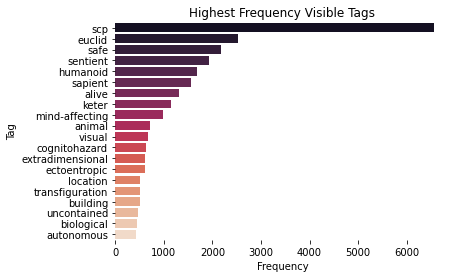

In [146]:
bar = seaborn.barplot([i[1] for i in tags_highest_counts_visible], [i[0] for i in tags_highest_counts_visible], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_title('Highest Frequency Visible Tags')
bar.set_xlabel('Frequency')
bar.set_ylabel('Tag')

In [58]:
# least common w counts
tags_lowest_counts = sorted(tag_counts, key= lambda x: x[1])[:20]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

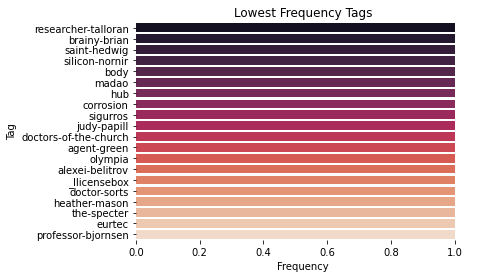

In [147]:
bar = seaborn.barplot([i[1] for i in tags_lowest_counts], [i[0] for i in tags_lowest_counts], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_title('Lowest Frequency Tags')
bar.set_xlabel('Frequency')
bar.set_ylabel('Tag')

# this shows us there's loads with a single tag, so will also list all tags that only appear once

In [60]:
one_off_tags = [i[0] for i in tag_counts if i[1]==1]
print(len(one_off_tags), one_off_tags)
# 31 tags of this type

31 ['researcher-talloran', 'brainy-brian', 'saint-hedwig', 'silicon-nornir', 'body', 'madao', 'hub', 'corrosion', 'sigurros', 'judy-papill', 'doctors-of-the-church', 'agent-green', 'olympia', 'alexei-belitrov', '_llicensebox', 'doctor-sorts', 'heather-mason', 'the-specter', 'eurtec', 'professor-bjornsen', 'glacon', 'plague-doctor', 'veronica-fitzroy', 'riven-mercer', 'halyna-ieva', 'rei2015', 'aaron-siegel', 'doctor-fynegan', 'cool-war-2', 'backdoor-soho', 'leslie']


### Ratings by Tag

In [61]:
# getting all ratings for articles with each tag
tag_ratings = {}

for i in unique_tags:
  article_num = 0
  ratings = 0
  rating_tags = [[i, y] for x, y in zip(scp_df['tags'], scp_df['rating']) if i in str(x)]
  tag_ratings[i] = [j[1] for j in rating_tags]

In [62]:
# averaging ratings for each tag
avg_tag_ratings = {}

for k,v in tag_ratings.items():
  avg_tag_ratings[k] = sum(v) / len(v)

In [75]:
# highest rated tags - **may not need this or can add to print more nicer 
import operator
highest_rated_tags = sorted(avg_tag_ratings.items(), reverse= True, key=lambda x: x[1])[:20]
print(highest_rated_tags)

[('researcher-talloran', 2206.0), ('3000', 503.7560975609756), ('simon-pietrykau', 485.0), ('agent-lament', 473.6666666666667), ('manna-charitable-foundation', 357.0), ('sculpture', 309.46153846153845), ('black-rabbit-company', 251.66666666666666), ('robert-bumaro', 247.14285714285714), ('nameless', 240.24137931034483), ('saint-hedwig', 222.0), ('daevite', 219.83333333333334), ('olfactory', 209.64705882352942), ('mathematical', 195.21153846153845), ('container', 189.00518134715026), ('knowledge', 172.95686274509805), ('tactile', 168.725), ('chemical', 167.55140186915887), ('reproductive', 166.9367088607595), ('wandsmen', 157.71428571428572), ('doctor-king', 157.33333333333334)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

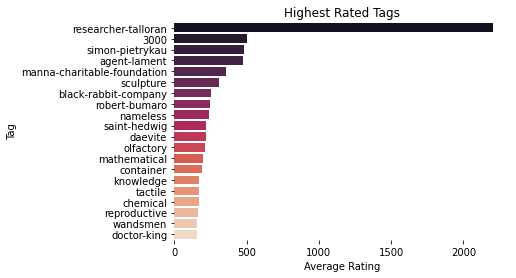

In [76]:
bar = seaborn.barplot([i[1] for i in highest_rated_tags], [i[0] for i in highest_rated_tags], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_title('Highest Rated Tags')
bar.set_xlabel('Average Rating')
bar.set_ylabel('Tag')
#something seems to have gone wrong here, highest rated avg should be higher than this? 
#looking at whole thing seems to have been sorted in slices

In [77]:
# lowest rated tags - **again prob adjust
lowest_rated_tags = sorted(avg_tag_ratings.items(), reverse= True, key=operator.itemgetter(1))[-20:]
print(lowest_rated_tags)

[('oneiroi', 123.4090909090909), ('musical', 122.44594594594595), ('vincent-anderson', 120.5), ('obskura', 118.53846153846153), ('general-bowe', 112.66666666666667), ('decommissioning-dept', 111.3), ('doctor-reynders', 104.75), ('_meets-the-eye', 103.63636363636364), ('professor-bjornsen', 100.0), ('isabel-v', 97.75), ('man-who-wasnt-there', 93.0), ('_shaggy-dog', 86.83333333333333), ('doctor-asheworth', 68.66666666666667), ('art-exchange', 67.125), ('doctor-gerald', 56.0), ('mages-academy', 51.5), ('_marine', 41.63157894736842), ('greazeburger', 35.5), ('backdoor-soho', 22.0), ('in-deletion', -15.166666666666666)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

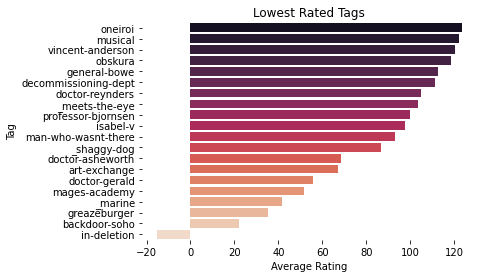

In [144]:
bar = seaborn.barplot([i[1] for i in lowest_rated_tags], [i[0] for i in lowest_rated_tags], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_title('Lowest Rated Tags')
bar.set_xlabel('Average Rating')
bar.set_ylabel('Tag')

The lowest rated tag is the only one with a negative average value, and represents articles that are soon going to be deleted

In [79]:
# tag frequency vs avg rating
freq_of_tags = dict([(i, len([x for x in list(scp_df['tags']) if i in str(x).split()])) for i in unique_tags])
print(freq_of_tags)

{'reproductive': 79, 'thermodynamic': 42, 'mathematical': 52, 'aquatic': 215, 'addictive': 40, 'daevite': 48, 'crystalline': 32, 'esterberg': 3, 'exquisite-corpse2020': 37, 'olfactory': 34, 'doctor-king': 3, 'researcher-talloran': 1, 'knowledge': 255, 'sculpture': 59, 'ijamea': 20, 'robert-bumaro': 7, 'container': 193, 'collab-con2019': 13, 'plant': 241, 'wandsmen': 7, 'black-rabbit-company': 3, 'manny': 6, 'avelar': 6, 'nameless': 29, 'brainy-brian': 1, 'saint-hedwig': 1, 'dental': 21, 'chemical': 107, 'tactile': 160, 'cadaver': 350, 's&c-plastics': 7, 'biohazard': 146, 'silicon-nornir': 1, '_graveyard-shift': 5, 'apollyon': 18, 'orcadia': 10, 'eric': 8, 'tactical-theology': 13, 'key': 8, 'weapon': 156, 'body': 1, 'doctor-rights': 2, 'heimdall': 5, 'collaboration': 9, 'immobile': 44, 'event-featured': 98, 'doctor-sinclair': 5, '_all-a-dream': 16, 'antimemetic': 158, 'reclamation': 15, 'safe': 2170, 'madao': 1, '_cc': 3243, 'doctor-roget': 3, 'automaton': 94, 'contagion': 147, 'vulpine

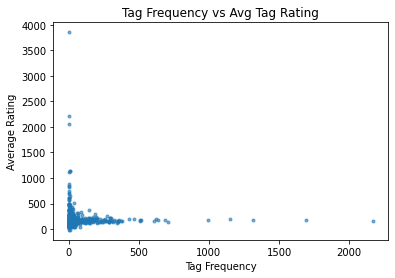

In [80]:
#plotting frequency of tag vs tag avg rating
fig1, ax1 = plt.subplots()
ax1.set_title('Tag Frequency vs Avg Tag Rating')
ax1.set_xlabel('Tag Frequency')
ax1.set_ylabel('Average Rating')
plt.scatter([v for k,v in freq_of_tags.items()], [v for k,v in avg_tag_ratings.items()], marker='.', alpha=0.6)

#### Ratings Adult Content vs Other

In [81]:
# average rating - age restricted
age_restricted = scp_df.loc[scp_df['state']=='age restricted']['rating']
avg_rating_adult = round(sum(age_restricted)/len(age_restricted))
print('Average rating for adult content: {}'.format(avg_rating_adult))

main_active = [i for i in scp_df.loc[scp_df['state']=='active']['rating'] if ~np.isnan(i)]
avg_main_rating = round(sum(main_active)/len(main_active))
print('Average rating for main articles: {}'.format(avg_main_rating))

Average rating for adult content: 265
Average rating for main articles: 171


Interestingly, the main batch of active articles have a significantly lower average rating than the smaller sample of 'age restricted' articles.

### Image Captions

In [122]:
# frequency
# % that have captions
have_captions = scp_df.loc[scp_df['image captions'].notna()]
have_captions_perc = len(have_captions) / len(scp_df) * 100
print('{}% of articles have at least one image with a caption'.format(round(have_captions_perc)))

# highest num of captions
captions = have_captions['image captions']
split_captions = [i.split(" \n ") for i in captions]
most_captions = max([len(i) for i in split_captions])
print('Highest number of captions in one article: {}'.format(most_captions))

pd.options.mode.chained_assignment = None

have_captions['image captions'] = have_captions['image captions'].map(lambda x: str(x).split(" \n "))
most_cap_article = max(have_captions['image captions'], key= lambda x: len(x))
most_cap_article = scp_df.loc[scp_df['image captions'] == " \n ".join(most_cap_article)]
print('Article with the most image captions: {}. Link: {}'.format(most_cap_article['title'].item(), most_cap_article['link'].item()))

44% of articles have at least one image with a caption
Highest number of captions in one article: 23
Article with the most image captions: "You Get Used to It". Link: https://scp-wiki.wikidot.com/scp-5045


In [ ]:
# caption word length
captions = list(captions)
captions = [" ".join(i) for i in captions]
captions = [i.split(' \n ') for i in captions]
captions = [" ".join(i) for i in captions]

In [131]:
avg_caption_length = sum(len(i.split()) for i in captions) / len(captions)
longest_cap_len, shortest_cap_len = max([ len(i) for i in captions]) ,  min([ len(i) for i in captions])
print('On average, a caption has {} words.'.format(round(avg_caption_length)))
print('The shortest caption is {} words long, and the longest caption is {} words long.'.format(shortest_cap_len, longest_cap_len ))

On average, a caption has 12 words.
The shortest caption is 2 words long, and the longest caption is 2822 words long.


In [137]:
# most common words
all_caption_words_str = remove_stopwords(quick_clean(" ".join(captions).replace("\"", "")))
print(all_caption_words_str)
# can anticipate that there will be loads of 'scp', cleaned version of captions that refer to the scp with its code

scp containment area close scps circuitry scp close scp scp scp prior recovery scp scp interior view scp file footage scp scp scp specimen scp growths civilian residence scp subject deceased ryugyong hotel located pyongyang democratic peoples republic korea depiction scp without everpresent secretions yazidi holy men shortly pilgrimage male scp instance scp made stand use electrified fence wire scp inside sleeve image capture scp experiment titled upshot knolte ford grable scp scp prior incident scp dormant state scp photo dr takeshi yamada static reproduction scp scp figure still frame taken video footage exploration figure b scp enhanced image still taken exploration scp transportation scpbs location order perform protocol scp scps storefront exterior scpb scp midemergence corrosion damage initial recovery cell containment procedures since revised agent release scp subject missing two hours subject remained alive one hour release interior view scp two scp specimens oozedrake left sli

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


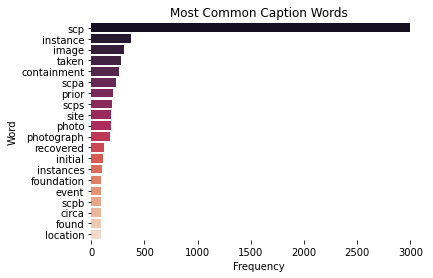

In [142]:
plot_most_common(get_most_common(all_caption_words_str), title='Most Common Caption Words')

# Text Analysis

In [157]:
# setting up and separating data
all_text_raw = scp_df['text']

text_single_str = quick_clean(" ".join(all_text_raw))
text_nostopwords_single_str = remove_stopwords(" ".join(text_single_str))
text_pos_tagged = pos_tag(text_nostopwords_single_str)

In [ ]:
# most common words, nouns, verbs, adjectives, 
plot_most_common(get_most_common(text_nostopwords_single_str))

In [ ]:
text_nouns_as_str = " ".join([i[0] for i in text_pos_tagged if i[1]=='NN'])
text_adjectives_as_str = " ".join([i[0] for i in text_pos_tagged if i[1]=='JJ'])
text_verbs_as_str = " ".join([i[0] for i in text_pos_tagged if i[1]=='VB'])

In [ ]:
create_wordcloud(text_nouns_as_str)

In [ ]:
create_wordcloud(text_adjectives_as_str)

In [ ]:
create_wordcloud(text_verbs_as_str)

In [ ]:
plot_most_common(get_most_common(text_nouns_as_str))

In [ ]:
plot_most_common(get_most_common(text_adjectives_as_str))

In [ ]:
plot_most_common(get_most_common(text_verbs_as_str))

In [ ]:
# average word length
text_word_split = [i.word_tokenize() for i in all_text_raw]
text_word_lens = [len(i) for i in text_word_split] 
avg_words_per_scp = sum(text_word_lens) / len(all_text_raw)

longest_words_per_scp, shortest_words_per_scp = max(text_word_lens), min(text_word_lens)
print('Average article word length: {}'.format(round(avg_words_per_scp)))
print('Longest article: {} words. Shortest article: {} words.'.format(round(longest_words_per_scp), round(shortest_words_per_scp)))

In [ ]:
# average sentence length
text_sent_split = [i.sent_tokenize() for i in all_text_raw]
text_sent_lens = [len(i) for i in text_sent_split]
avg_sents_per_scp = sum(text_sent_lens) / len(all_text_raw)

longest_sents_per_scp, shortest_sents_per_scp = max(text_sent_lens), min(text_sent_lens)
print('Average article sentence length: {}'.format(round(avg_sents_per_scp)))
print('Longest article: {} sentences. Shortest article: {} sentences.'.format(round(longest_sents_per_scp), round(shortest_sents_per_scp)))

### States

In [ ]:
# NB made these quick placeholders, some of these states have now been combined and code below will need to be changed

# numbers of each 
df_len = len(scp_df)

# active
active_num = len(scp_df.loc[scp_df['state']=='active']) 
active_perc = active_num / df_len * 100
print('Assumed active (not deleted or restricted) articles make up {}% of all articles, with {} entries'.format(round(active_perc, 1), active_num))

# blocked
blocked_num = len(scp_df.loc[scp_df['state']=='blocked']) 
blocked_perc = blocked_num / df_len * 100
print('Blocked articles make up {}% of all articles, with {} entries'.format(round(blocked_perc, 1), blocked_num))

# age restricted
adult_num = len(scp_df.loc[scp_df['state']=='age restricted']) 
adult_perc = adult_num / df_len * 100
print('Age restricted articles make up {}% of all articles, with {} entries'.format(round(adult_perc, 1), adult_num))

# deleted
deleted_num = len(scp_df.loc[scp_df['state']=='deleted']) 
deleted_perc = deleted_num / df_len * 100
print('Deleted articles make up {}% of all articles, with {} entries'.format(round(deleted_perc, 1), deleted_num))

# clearance required
clearance_num = len(scp_df.loc[scp_df['state']=='restricted']) 
clearance_perc = clearance_num / df_len * 100
print('Restricted articles make up {}% of all articles, with {} entries'.format(round(clearance_perc), 1), clearance_num))